In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import sklearn.datasets
import torch.utils.data
from torch import nn
from torch.nn import functional as F
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torchmetrics.classification import BinaryAccuracy

sns.set()

# Set random seed for PyTorch
torch.manual_seed(42)

# Set random seed for NumPy
np.random.seed(42)

In [2]:
DEBUG_MODE = False

def debug(input):
    if DEBUG_MODE == True:
        print(input)
    else:
        pass

In [3]:
NOISE = 0.1
BS = 64
NUM_EP = 50
LR = 0.01
LS = 0.0 # Label smoothing 

NUM_CLASSES = 2

input_dim = 2
hidden_dim = 64
output_dim = NUM_CLASSES
output_dim_u = NUM_CLASSES + 1

DOMAIN = 3

# Parameters for SGD Optimizer
momentum = 0.9
weight_decay = 1e-4

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [4]:
# Model
class DynamicModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, softmax=False, dropout_prob=0.0):
        super(DynamicModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.softmax = softmax
        self.softmax_function = nn.Softmax(dim=1)
        self.dropout_prob = dropout_prob

        # Define layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x
    
        # if self.output_dim == 2:
        #     x = self.fc4(x)
        #     return x if self.softmax == False else self.softmax_function(x)
        # if self.output_dim > 2: 
        #     x = self.fc4(x)
        #     h = x[:, :2]
        #     additional_params = x[:, 2:]
        #     return x

In [5]:
def train(model, criterion, optimizer, num_epochs = NUM_EP):
    
    losses = []
    accuracy_scores = []
    
    metric = BinaryAccuracy(multidim_average='samplewise')

    for epoch in range(num_epochs):
        running_loss = 0.0
        accuracies = []
        for inputs, labels in train_loader: # train_loader is defined outside the function
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            accuracy = metric(nn.functional.softmax(outputs[:, :NUM_CLASSES],1), labels)
            accuracies.append(accuracy)
            running_loss += loss.item()
        #print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")
        losses.append(running_loss)
        accuracy_scores.append(np.mean(accuracies))
    print('Training Completed')
    print(f' Average Accuracy: {np.mean(accuracy_scores)}')
    
    return losses, accuracy_scores, model

In [6]:
class UANLLoss(nn.Module):
    def __init__(self, label_smoothing = 0.1):
        super(UANLLoss, self).__init__()
        self.confidence = 1.0 - label_smoothing
        self.smoothing = label_smoothing
        #self.clc = classes
        
    def forward(self,x,y):
        # m = y.size(0)  # batch size
        # N = y.size(1)  # number of classes
        #debug(f'N: {N}')
        logstd  = (x[:,NUM_CLASSES:]) ** 2 #torch.sigmoid(x[:,self.clc:])#(x[:,NUM_CLASSES:]) ** 2#
        prob = x[:,:NUM_CLASSES]#nn.functional.softmax(x[:,:NUM_CLASSES],1)

        with torch.no_grad():
            yoh = torch.zeros_like(prob)
            yoh.fill_(self.smoothing / (NUM_CLASSES - 1))
            debug(f'yoh shape: {yoh.shape}')
            debug(f'y.data shape: {y.data.shape}')
            #debug(f'y.data shape unsqueeze: {y.data.unsqueeze(1).unsqueeze(1)}')
            yoh.scatter_(1, y.data.to(torch.int64), self.confidence)

        #loss0 = (yoh - prob) ** 2
        loss0 = (y - prob) ** 2
        loss = (torch.exp(-logstd) * loss0.sum(dim=1) + NUM_CLASSES * logstd)
        return loss.mean() #loss.mean() #(1.0 - cosyh).mean() #loss

In [7]:
class UACSLoss(nn.Module):
    def __init__(self, label_smoothing=0.1):
        super(UACSLoss, self).__init__()
        self.confidence = 1.0 - label_smoothing
        self.smoothing = label_smoothing

    def forward(self,x,y):
        unc  = torch.sigmoid(x[:,NUM_CLASSES:])
        cos = nn.CosineSimilarity(dim=1)
        prob = nn.functional.softmax(x[:,:NUM_CLASSES],1)

        with torch.no_grad():
            _, yy = torch.max(y,1)
            yy = yy.unsqueeze(dim=1)
            yoh = torch.zeros_like(prob)
            yoh.fill_(self.smoothing / (NUM_CLASSES - 1))
            yoh.scatter_(1, yy.data.to(torch.int64), self.confidence)

        cosyh = cos(yoh,prob)
        loss0 = -((1.0 - cosyh) * torch.log(unc / (NUM_CLASSES - 1)))
        loss1 = -(cosyh * torch.log(1 - unc))
        loss = (loss0 + loss1).mean()

        return loss

# Uncertainty visualization function

In [8]:
def plot_model_predictions(model, mode = 'single', domain = DOMAIN, num_classes = NUM_CLASSES, num_epochs = NUM_EP, noise = NOISE, loss_title = 'CE'):
    sns.set()
    
    x_lin = np.linspace(-domain + 0.5, domain + 0.5, 200)
    y_lin = np.linspace(-domain, domain, 200)

    xx, yy = np.meshgrid(x_lin, y_lin)

    X_grid = np.column_stack([xx.flatten(), yy.flatten()])

    X_vis, y_vis = sklearn.datasets.make_moons(n_samples=500, noise=noise)
    mask = y_vis.astype(np.bool_)
    
    if mode == 'single':
        with torch.no_grad():
            output = model(torch.from_numpy(X_grid).float())
            output = nn.functional.softmax(output[:, :num_classes], 1)
            confidence, _ = torch.max(output, dim=1)
            # Range of certainty values
    elif mode == 'ensemble':
        with torch.no_grad():
            predictions = torch.stack([nn.functional.softmax(single_model(torch.from_numpy(X_grid).float())[:, :2], dim=1) for single_model in model])
            mean_prediction = torch.mean(predictions.exp(), dim=0)
            confidence = torch.sum(mean_prediction * torch.log(mean_prediction), dim=1)
    
    min_confidence = torch.min(confidence)
    max_confidence = torch.max(confidence)

    confidence = (confidence - min_confidence) / (max_confidence - min_confidence)

    z = confidence.reshape(xx.shape)
    
    vmin = 0
    vmax = 1.0

    plt.figure()
    contour = plt.contourf(x_lin, y_lin, z, cmap='cividis', vmin = vmin, vmax = vmax)
    
    cbar = plt.colorbar(contour)
    cbar.set_ticks(np.linspace(vmin, vmax, 5))
    
    plt.xticks([])
    plt.yticks([])
    
    print(f'z_min: {z.min()}\n z_max: {z.max()}')

    plt.scatter(X_vis[mask, 0], X_vis[mask, 1], alpha=0.25, color='orange')
    plt.scatter(X_vis[~mask, 0], X_vis[~mask, 1], alpha=0.25, color='royalblue')
    #plt.title(f'{loss_title} Loss, mode = {mode}, domain = {domain}, epochs: {num_epochs}', fontweight = 'bold', pad = 20)
    
    plt.savefig(f'{loss_title}_{mode}')


# Data Loader

In [9]:
X_train, y_train = sklearn.datasets.make_moons(n_samples=1000, noise=NOISE)
X_test,  y_test  = sklearn.datasets.make_moons(n_samples=200,  noise=NOISE)

train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), F.one_hot(torch.from_numpy(y_train)).float())
test_dataset  = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(),  F.one_hot(torch.from_numpy(y_test)).float())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BS, shuffle=True, drop_last=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=BS, shuffle=False)

# CE Loss [Single]

Training Completed
 Average Accuracy: 0.9575208425521851


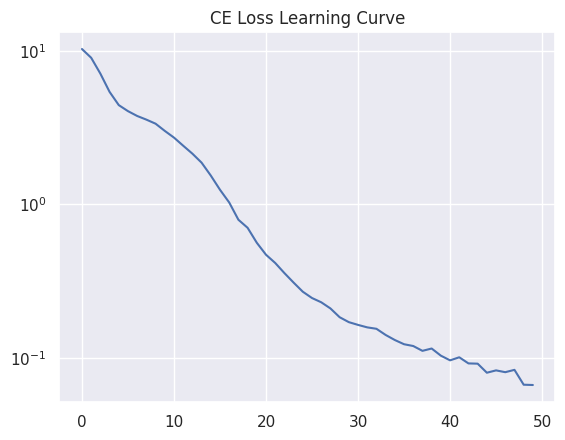

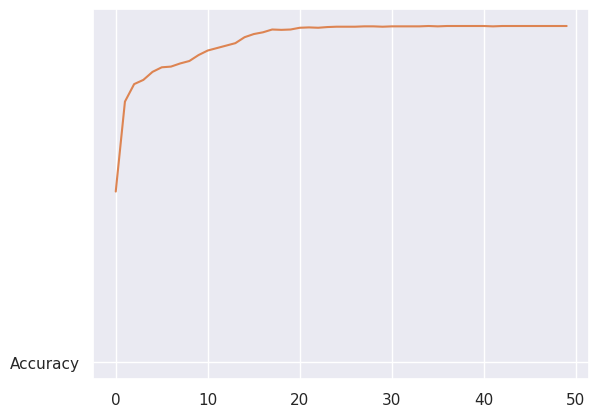

In [10]:
model = DynamicModel(input_dim, hidden_dim, output_dim)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing = LS)
optimizer = optim.SGD(model.parameters(), lr=LR, momentum = momentum) # weight_decay = weight_decay)

# Training loop
losses, accuracy, model = train(model, criterion, optimizer)   
    
plt.semilogy(losses)
plt.title('CE Loss Learning Curve')
plt.show()

plt.plot('Accuracy')
plt.plot(accuracy)
plt.show()

z_min: 0.0
 z_max: 1.0


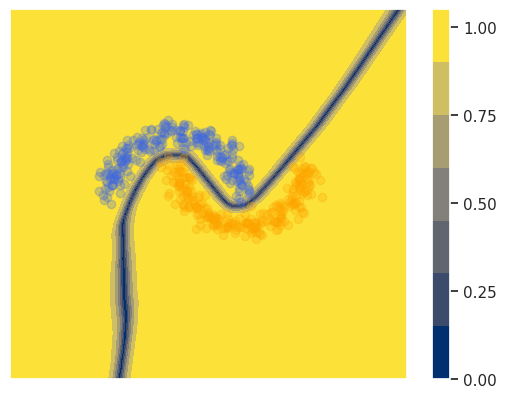

In [11]:
plot_model_predictions(model, loss_title = 'CE')

In [12]:
del model

# UANLL Loss [Single]

Training Completed
 Average Accuracy: 0.9762084484100342


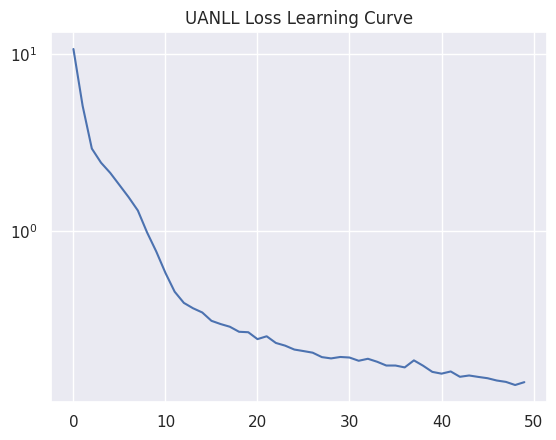

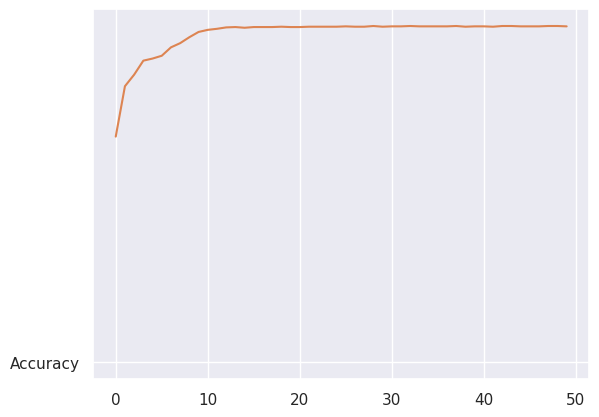

In [13]:
model = DynamicModel(input_dim, hidden_dim, output_dim_u)

# Setting Loss criterion and Optimizer
criterion = UANLLoss(label_smoothing = LS)
optimizer = optim.SGD(model.parameters(), lr=LR, momentum = momentum, weight_decay = weight_decay)

# Training loop
losses, accuracy, model = train(model, criterion, optimizer)   
    
plt.semilogy(losses)
plt.title('UANLL Loss Learning Curve')
plt.show()

plt.plot('Accuracy')
plt.plot(accuracy)
plt.show()

z_min: 0.0
 z_max: 1.0


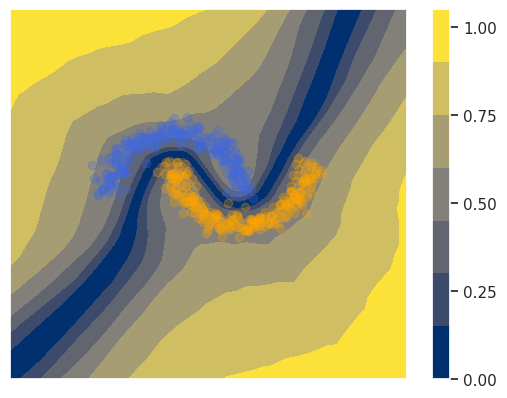

In [14]:
plot_model_predictions(model, loss_title = 'UANLL')

In [15]:
del model

# UACS Loss Single

Training Completed
 Average Accuracy: 0.9438541531562805


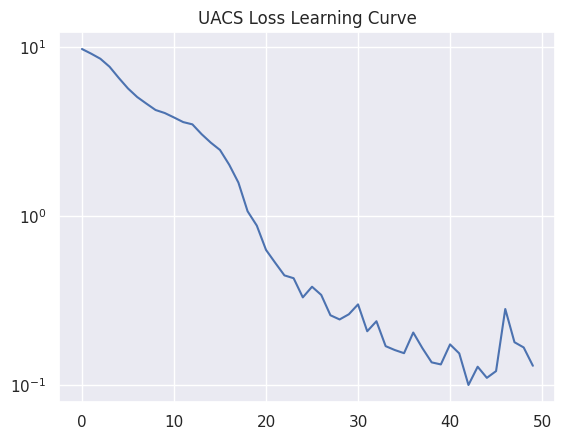

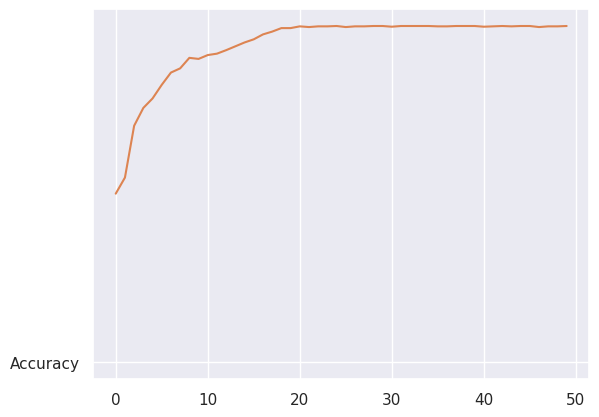

In [16]:
model = DynamicModel(input_dim, hidden_dim, output_dim_u)

# Setting Loss criterion and Optimizer
criterion = UACSLoss(label_smoothing = LS)
optimizer = optim.SGD(model.parameters(), lr=LR, momentum = momentum, weight_decay = weight_decay)

# Training loop
losses, accuracy, model = train(model, criterion, optimizer)   
    
plt.semilogy(losses)
plt.title('UACS Loss Learning Curve')
plt.show()

plt.plot('Accuracy')
plt.plot(accuracy)
plt.show()

z_min: 0.0
 z_max: 1.0


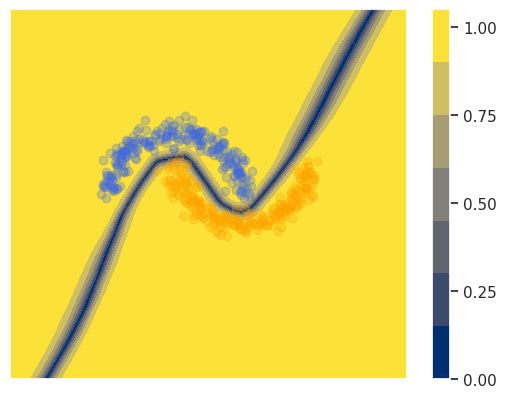

In [17]:
plot_model_predictions(model, loss_title = 'UACS')

In [18]:
del model

# CE Loss [Label Smoothing + WD experiments]

In [19]:
LS_exp = 0.4
WD_exp = 1e-2

Training Completed
 Average Accuracy: 0.9588541984558105


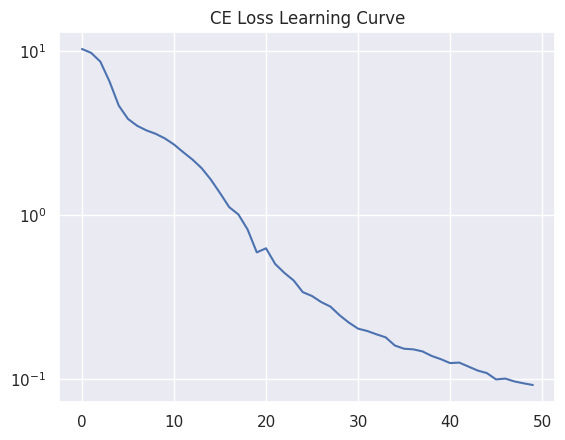

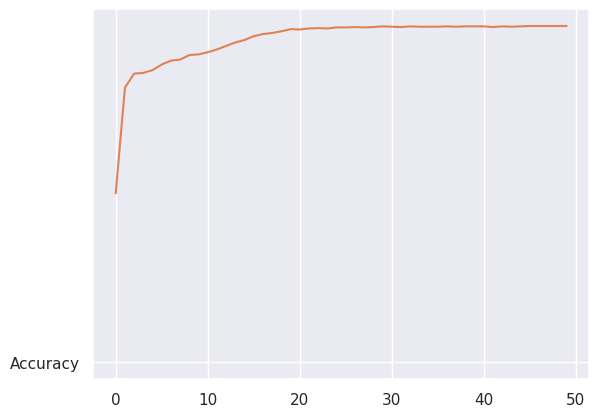

In [20]:
model = DynamicModel(input_dim, hidden_dim, output_dim)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum = momentum)

# Training loop
losses, accuracy, model = train(model, criterion, optimizer)   
    
plt.semilogy(losses)
plt.title('CE Loss Learning Curve')
plt.show()

plt.plot('Accuracy')
plt.plot(accuracy)
plt.show()

z_min: 0.0
 z_max: 1.0


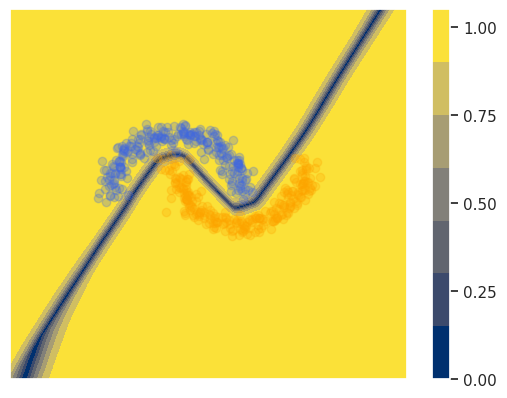

In [21]:
plot_model_predictions(model, loss_title = 'CE_no_wd')

In [22]:
del model

Training Completed
 Average Accuracy: 0.9389582872390747


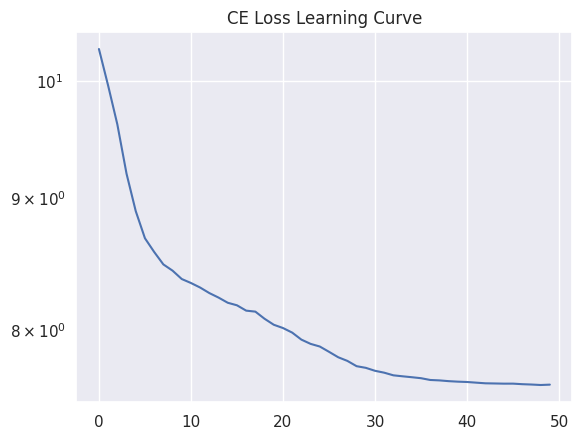

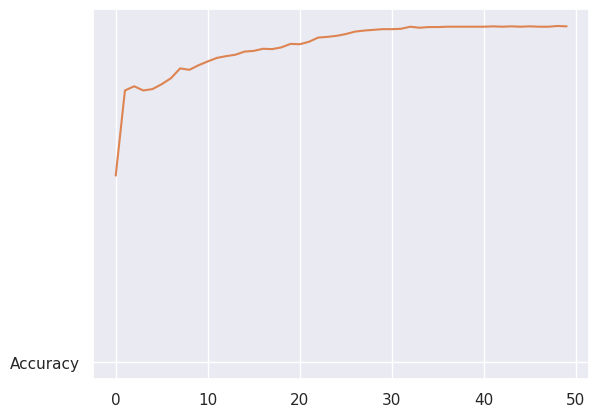

In [23]:
model = DynamicModel(input_dim, hidden_dim, output_dim, softmax = True)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing = LS_exp)
optimizer = optim.SGD(model.parameters(), lr=LR, momentum = momentum)

# Training loop
losses, accuracy, model = train(model, criterion, optimizer)   
    
plt.semilogy(losses)
plt.title('CE Loss Learning Curve')
plt.show()

plt.plot('Accuracy')
plt.plot(accuracy)
plt.show()

z_min: 0.0
 z_max: 1.0


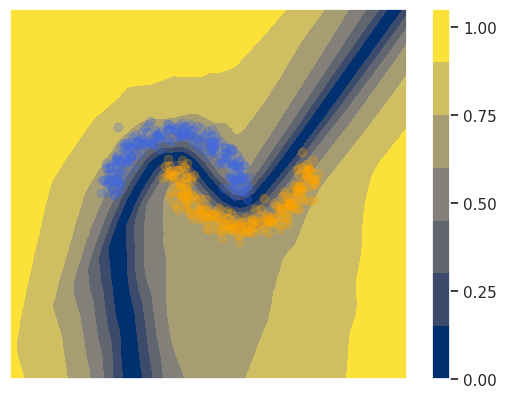

In [24]:
plot_model_predictions(model, loss_title = f'CE_ls04_no_wd')

In [25]:
del model

Training Completed
 Average Accuracy: 0.9068541526794434


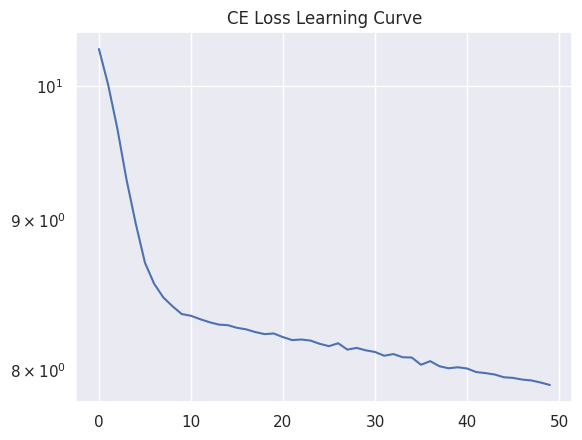

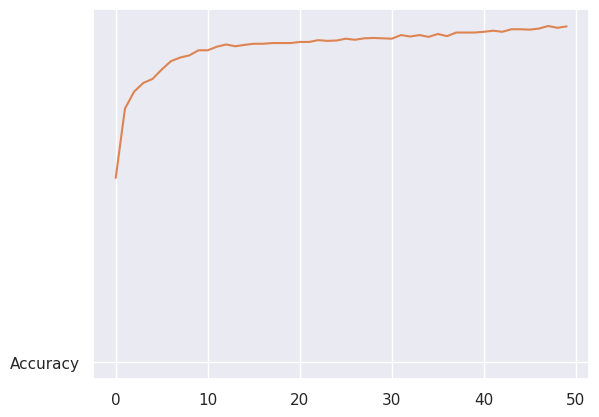

In [26]:
model = DynamicModel(input_dim, hidden_dim, output_dim, softmax = True)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing = LS_exp)
optimizer = optim.SGD(model.parameters(), lr=LR, momentum = momentum, weight_decay = WD_exp)

# Training loop
losses, accuracy, model = train(model, criterion, optimizer)   
    
plt.semilogy(losses)
plt.title('CE Loss Learning Curve')
plt.show()

plt.plot('Accuracy')
plt.plot(accuracy)
plt.show()

z_min: 0.0
 z_max: 1.0


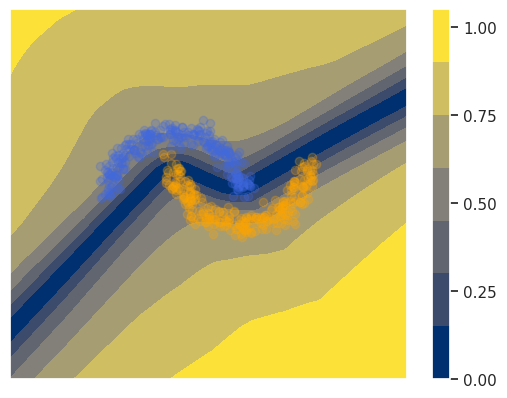

In [27]:
plot_model_predictions(model, loss_title = f'CE_ls04_wd2e-2')

In [28]:
del model

# CE Loss [Ensemble]

In [29]:
models = []
for _ in range(5):
    model = DynamicModel(input_dim, hidden_dim, output_dim, dropout_prob = 0.1)
    # Setting Loss criterion and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum = momentum)
    loss, accuracy, model = train(model, criterion, optimizer)   
    models.append(model)

Training Completed
 Average Accuracy: 0.9437708258628845
Training Completed
 Average Accuracy: 0.9423959255218506
Training Completed
 Average Accuracy: 0.940583348274231
Training Completed
 Average Accuracy: 0.9550208449363708
Training Completed
 Average Accuracy: 0.9434375166893005


z_min: 0.0
 z_max: 1.0


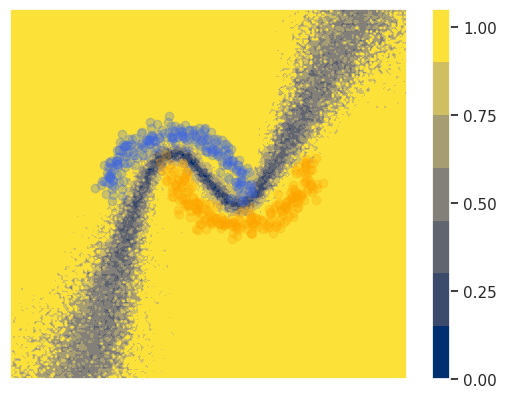

In [30]:
plot_model_predictions(model = models, mode = 'ensemble', loss_title = 'CE')

# UANLL Loss [Ensemble]

In [31]:
models = []
for _ in range(5):
    model = DynamicModel(input_dim, hidden_dim, output_dim_u, dropout_prob = 0.1)
    # Setting Loss criterion and Optimizer
    criterion = UANLLoss()
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum = momentum, weight_decay = weight_decay)
    loss, accuracy, model = train(model, criterion, optimizer)   
    models.append(model)

Training Completed
 Average Accuracy: 0.9655625224113464
Training Completed
 Average Accuracy: 0.9675417542457581
Training Completed
 Average Accuracy: 0.9659584164619446
Training Completed
 Average Accuracy: 0.9592916965484619
Training Completed
 Average Accuracy: 0.9719374775886536


z_min: 0.0
 z_max: 1.0


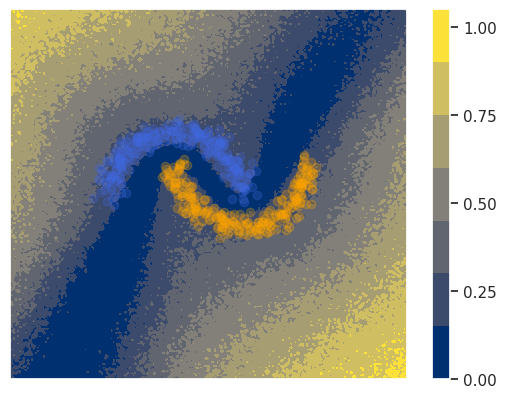

In [32]:
plot_model_predictions(model = models, mode = 'ensemble', loss_title = 'UANLL')

# UACS Loss [Ensemble]

In [33]:
models = []
for _ in range(5):
    model = DynamicModel(input_dim, hidden_dim, output_dim_u, dropout_prob = 0.1)
    # Setting Loss criterion and Optimizer
    criterion = UACSLoss()
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum = momentum, weight_decay = weight_decay)
    loss, accuracy, model = train(model, criterion, optimizer)   
    models.append(model)

Training Completed
 Average Accuracy: 0.9388958215713501
Training Completed
 Average Accuracy: 0.9398542046546936
Training Completed
 Average Accuracy: 0.936916708946228
Training Completed
 Average Accuracy: 0.9360209107398987
Training Completed
 Average Accuracy: 0.9273542165756226


z_min: 0.0
 z_max: 1.0


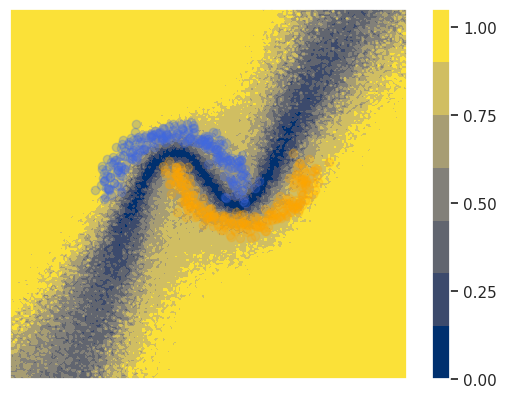

In [34]:
plot_model_predictions(model = models, mode = 'ensemble', loss_title = 'UACS')